In [5]:
%matplotlib inline
#from ROOT import TFile, TTree

import numpy as np
#from numpy import polyfit
#from numpy import random
import matplotlib.pylab as plt
#from matplotlib.colors import LogNorm
import pandas as pd
#from matplotlib import gridspec
#from scipy.stats import norm

from root_numpy import root2array

In [6]:
# Do you want to write figures to png files? Careful, it will overwrite!
write_figures = True
figdir = 'Figures/'

In [7]:
filedir = 'anafiles/'
!ls -ltra $filedir | tail -n 5
anatype = 'MCBNBRecoTrack'

seglen = 10
fb = ['FORWARDS', 'BACKWARDS']

mybasequery = 'MCT_PDG == 13 or MCT_PDG == -13'

-rw-r--r--   1 davidkaleko  staff    1167266 Nov 19 12:02 MCSBiasStudy_SingleMuonMCTrack_anaout_10cmseg_2res_bothscatters_nonrelfix.root
-rw-r--r--   1 davidkaleko  staff   21994235 Nov 19 12:14 MCSBiasStudy_MCBNBRecoTrack_anaout_10cmseg_2res_bothscatters_nonrelfix_BACKWARDS.root
drwxr-xr-x  18 davidkaleko  staff        612 Nov 19 12:15 .
-rw-r--r--   1 davidkaleko  staff   22037126 Nov 19 12:16 MCSBiasStudy_MCBNBRecoTrack_anaout_10cmseg_2res_bothscatters_nonrelfix_FORWARDS.root
drwxr-xr-x  23 davidkaleko  staff        782 Nov 19 12:16 ..


In [19]:
df_dict = {}
segdf_dict = {}

for myfb in fb:
    myfile = 'MCSBiasStudy_%s_anaout_%dcmseg_2res_bothscatters_nonrelfix_%s.root' % (anatype, seglen, myfb)
    
    df_dict[myfb] = pd.DataFrame( root2array ( filedir + myfile, 'MCS_bias_tree' ) )
    #This df has track-by-track information (MCS energy, range energy, etc)
    df_dict[myfb]['full_MCS_energy_inverse'] = 1./df_dict[myfb]['full_MCS_energy']
    df_dict[myfb]['full_range_energy_inverse'] = 1./df_dict[myfb]['full_range_energy']
    
    #This df has segment-by-segment deviation (scattering angle, etc)
    segdf_dict[myfb] = pd.DataFrame( root2array ( filedir + myfile, 'TMC_debug_tree' ) )
    segdf_dict[myfb]['dthetayoverpredictedRMS'] = \
        segdf_dict[myfb]['delta_theta_y']/segdf_dict[myfb]['predicted_RMS']
    segdf_dict[myfb]['dthetayoverpredictedRMS_fromMCS'] = \
        segdf_dict[myfb]['delta_theta_y']/segdf_dict[myfb]['predicted_RMS_fromMCS']
    
    segdf_dict[myfb]['dthetaxoverpredictedRMS'] = \
        segdf_dict[myfb]['delta_theta_x']/segdf_dict[myfb]['predicted_RMS']
    segdf_dict[myfb]['dthetaxoverpredictedRMS_fromMCS'] = \
        segdf_dict[myfb]['delta_theta_x']/segdf_dict[myfb]['predicted_RMS_fromMCS']

    #Driver DF tree that holds some MCTrack information
    driverdf = pd.DataFrame( root2array ( filedir + myfile, 'driver_tree' ) )

    #Merge it into the main dfs by run,subrun,eventid
    df_dict[myfb] = df_dict[myfb].merge(driverdf, on=['run','subrun','eventid'])
    segdf_dict[myfb] = segdf_dict[myfb].merge(driverdf, on=['run','subrun','eventid'])

In [20]:
print segdf_dict['FORWARDS'].columns.values
print df_dict['FORWARDS'].columns.values

['full_track_len' 'full_MCS_E' 'full_range_E' 'delta_theta_x'
 'delta_theta_y' 'seg_end_x' 'seg_end_y' 'seg_end_z' 'n_traj_points'
 'seg_theta' 'seg_phi' 'counter' 'true_segment_E' 'true_predicted_RMS'
 'segment_E' 'predicted_RMS' 'segment_E_fromMCS' 'predicted_RMS_fromMCS'
 'resid_dist' 'llbf' 'run' 'subrun' 'eventid' 'dthetayoverpredictedRMS'
 'dthetayoverpredictedRMS_fromMCS' 'dthetaxoverpredictedRMS'
 'dthetaxoverpredictedRMS_fromMCS' 'MCT_PDG' 'MCT_origin']
['full_length' 'full_range_energy' 'full_range_momentum' 'full_MCS_energy'
 'full_MCS_momentum' 'true_E' 'run' 'subrun' 'eventid'
 'full_MCS_energy_inverse' 'full_range_energy_inverse' 'MCT_PDG'
 'MCT_origin']


In [21]:
#Now, segdf dicts have one entry per segment, but for now I'm interested in
#the minimum likelihood for each *track*... the segdf just has the same value
#for this N times for each track.
for myfb in segdf_dict.keys():
    segdf_dict[myfb] = segdf_dict[myfb].drop_duplicates(subset=['run','subrun','eventid'])


SAVING FIGURE! TrackDirection_MCBNBRecoTrack_LLHDoverlay.png
SAVING FIGURE! TrackDirection_MCBNBRecoTrack_LLHDdiff.png


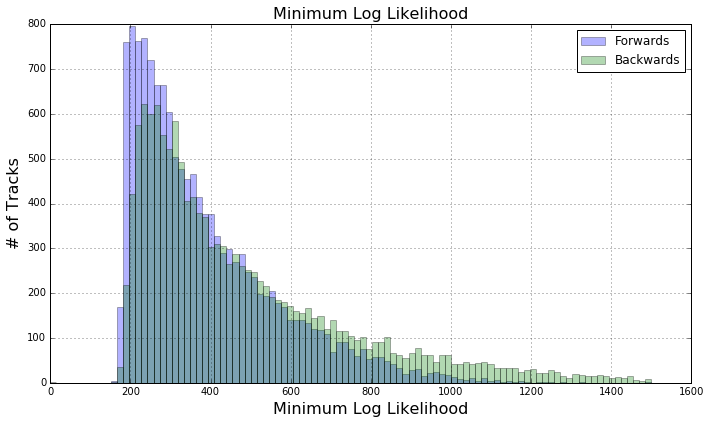

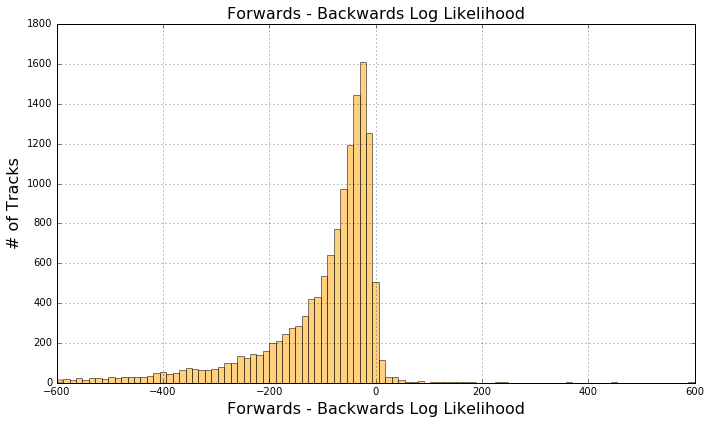

In [29]:
plt.figure(figsize=(10,6))
forwards_llbf = segdf_dict['FORWARDS'].query(mybasequery)['llbf'].values
backwards_llbf = segdf_dict['BACKWARDS'].query(mybasequery)['llbf'].values
diff_llbf = forwards_llbf-backwards_llbf
thebins = bins=np.linspace(0,1500,100)
blah = plt.hist(forwards_llbf,bins=thebins,label='Forwards',alpha=0.3)
blah = plt.hist(backwards_llbf,bins=thebins,label='Backwards',alpha=0.3)
dummy = plt.legend()
dummy = plt.title('Minimum Log Likelihood',fontsize=16)
dummy = plt.ylabel('# of Tracks',fontsize=16)
dummy = plt.xlabel('Minimum Log Likelihood',fontsize=16)
dummy = plt.grid(True)
if write_figures:
    print "SAVING FIGURE!",'TrackDirection_MCBNBRecoTrack_LLHDoverlay.png'
    plt.tight_layout()
    plt.savefig(figdir+'TrackDirection_MCBNBRecoTrack_LLHDoverlay.png')


plt.figure(figsize=(10,6))
forwards_llbf = segdf_dict['FORWARDS'].query(mybasequery)['llbf'].values
backwards_llbf = segdf_dict['BACKWARDS'].query(mybasequery)['llbf'].values
diff_llbf = forwards_llbf-backwards_llbf


blah = plt.hist(diff_llbf,bins=np.linspace(-600,600,100),alpha=0.5,color='orange')
dummy = plt.title('Forwards - Backwards Log Likelihood',fontsize=16)
dummy = plt.ylabel('# of Tracks',fontsize=16)
dummy = plt.xlabel('Forwards - Backwards Log Likelihood',fontsize=16)
dummy = plt.grid(True)
if write_figures:
    print "SAVING FIGURE!",'TrackDirection_MCBNBRecoTrack_LLHDdiff.png'
    plt.tight_layout()
    plt.savefig(figdir+'TrackDirection_MCBNBRecoTrack_LLHDdiff.png')